In [ ]:
##use the fc5 feature and ranking (total run with online update)

In [2]:
import numpy as np
import os
import sys
import time
import argparse
import json
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable,Function
sys.path.insert(0,'/home/prisimage/tracker/py-MDNetST/modules')
from sample_generator import *
from data_prov import *
from model import *
from bbreg import *
from options import *
from gen_config import *
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
def show_bbox(image,bboxes):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    for i in range(len(bboxes)):
        rect = plt.Rectangle(tuple(bboxes[i,:2]),bboxes[i,2],bboxes[i,3], 
                             linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
        ax.add_patch(rect)
def show_result(image,bbox):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    rect = plt.Rectangle(tuple(bbox[:2]),bbox[2],bbox[3], linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)
def show_grid(image,samples,num):
    image = np.asarray(image)
    sample_arr = list()
    image = np.asarray(image)
    for i in range(num):
        sample_img = crop_image(image,samples[i],107,0)
        sample_arr.append(sample_img)
    d = np.stack(sample_arr,axis=0)
    torch_img = torchvision.utils.make_grid(torch.from_numpy(np.transpose(d,(0,3,1,2))))
    npimg = torch_img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
def set_optimizer(model, lr_base, lr_mult=opts['lr_mult'], momentum=opts['momentum'], w_decay=opts['w_decay']):
    params = model.get_learnable_params()
    param_list = []
    for k, p in params.iteritems():
        lr = lr_base
        for l, m in lr_mult.iteritems():
            if k.startswith(l):
                lr = lr_base * m
        param_list.append({'params': [p], 'lr':lr})
    optimizer = optim.SGD(param_list, lr = lr, momentum=momentum, weight_decay=w_decay)
    return optimizer
def show_bbox(image,bboxes):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    for i in range(len(bboxes)):
        rect = plt.Rectangle(tuple(bboxes[i,:2]),bboxes[i,2],bboxes[i,3], 
                             linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
        ax.add_patch(rect)
def show_result(image,bbox):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    rect = plt.Rectangle(tuple(bbox[:2]),bbox[2],bbox[3], linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)
def forward_samples(model, image, samples, out_layer='conv3'):
    model.eval()
    extractor = RegionExtractor(image, samples, opts['img_size'], opts['padding'], opts['batch_test'])
    for i, regions in enumerate(extractor):
        regions = Variable(regions)
        if opts['use_gpu']:
            regions = regions.cuda()
        feat = model(regions, out_layer=out_layer)
        if i==0:
            feats = feat.data.clone()
        else:
            feats = torch.cat((feats,feat.data.clone()),0)
    return feats
def train(model, tripletloss, optimizer, pos_feats, neg_feats, maxiter, in_layer='fc4'):
    model.train()
    batch_anc = 96
    batch_pos = 96
    batch_neg = 96
    batch_test = opts['batch_test']
    #batch_neg_cand = max(opts['batch_neg_cand'], batch_neg)
    anc_idx = np.random.permutation(pos_feats.size(0))
    pos_idx = np.random.permutation(pos_feats.size(0))
    neg_idx = np.random.permutation(neg_feats.size(0))
    while(len(anc_idx) < batch_anc*maxiter):
        anc_idx = np.concatenate([anc_idx, np.random.permutation(pos_feats.size(0))])
    while(len(pos_idx) < batch_pos*maxiter):
        pos_idx = np.concatenate([pos_idx, np.random.permutation(pos_feats.size(0))])
    while(len(neg_idx) < batch_neg*maxiter):
        neg_idx = np.concatenate([neg_idx, np.random.permutation(neg_feats.size(0))])
    anc_pointer = 0
    pos_pointer = 0
    neg_pointer = 0

    for iter in range(maxiter):
        # select anc idx
        anc_next = anc_pointer+batch_anc
        anc_cur_idx = anc_idx[anc_pointer:anc_next]
        anc_cur_idx = pos_feats.new(anc_cur_idx).long()
        anc_pointer = anc_next
        
        # select pos idx
        pos_next = pos_pointer+batch_pos
        pos_cur_idx = pos_idx[pos_pointer:pos_next]
        pos_cur_idx = pos_feats.new(pos_cur_idx).long()
        pos_pointer = pos_next

        # select neg idx
        neg_next = neg_pointer+batch_neg
        neg_cur_idx = neg_idx[neg_pointer:neg_next]
        neg_cur_idx = neg_feats.new(neg_cur_idx).long()
        neg_pointer = neg_next

        # create batch
        batch_anc_feats = Variable(pos_feats.index_select(0, anc_cur_idx))
        batch_pos_feats = Variable(pos_feats.index_select(0, pos_cur_idx))
        batch_neg_feats = Variable(neg_feats.index_select(0, neg_cur_idx))

        
        # forward
        anc_fc5 = model(batch_anc_feats, in_layer=in_layer,out_layer='fc5')
        pos_fc5 = model(batch_pos_feats, in_layer=in_layer,out_layer='fc5')
        neg_fc5 = model(batch_neg_feats, in_layer=in_layer,out_layer='fc5')
        
        # optimize
        loss = tripletloss(anc_fc5,pos_fc5,neg_fc5)
        print(loss)
        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), opts['grad_clip'])
        optimizer.step()

        #print "Iter %d, Loss %.4f" % (iter, loss.data[0])
#import cv2
def cvshow(img):
    cv2.imshow("Image",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
def stackList(featList):
    nframes = len(featList)
    for start in range(nframes):
        if start == 0:
            pos_data = featList[start].clone()
        else:
            pos_data = torch.cat((pos_data,featList[start].clone()),0)
    return pos_data    

        

np.random.seed(123)
torch.manual_seed(456)
torch.cuda.manual_seed(789)
seq_home = '../dataset/OTB'
save_home = '../result_fig'
result_home = '../result'
        
seq_name = 'Matrix'
img_dir = os.path.join(seq_home, seq_name, 'img')
gt_path = os.path.join(seq_home, seq_name, 'groundtruth_rect.txt')

img_list = os.listdir(img_dir)
img_list.sort()
img_list = [os.path.join(img_dir,x) for x in img_list]

gt = np.loadtxt(gt_path,delimiter=',')
init_bbox = gt[0]
        
savefig_dir = os.path.join(save_home,seq_name)
result_dir = os.path.join(result_home,seq_name)
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
result_path = os.path.join(result_dir,'result.json')
# get imglist,gt
target_bbox = np.array(init_bbox)
result = np.zeros((len(img_list),4))
result_bb = np.zeros((len(img_list),4))
result[0] = target_bbox
result_bb[0] = target_bbox
#init the first target box and result array
#os.environ['CUDA_VISIBLE_DEVICES'] = "1"
model = MDNet(opts['model_path'])
if opts['use_gpu']:
    model = model.cuda()

model.set_learnable_params(opts['ft_layers'])
#init model and set learnable layers
pdist = PairwiseDistance()
tripletloss = torch.nn.TripletMarginLoss(margin=1.0, p=2)

image = Image.open(img_list[0]).convert('RGB')
bbreg_examples = gen_samples(SampleGenerator('uniform', image.size, 0.3, 1.5, 1.1),target_bbox, opts['n_bbreg'], opts['overlap_bbreg'], opts['scale_bbreg'])
bbreg_feats = forward_samples(model, image, bbreg_examples)
bbreg = BBRegressor(image.size)
bbreg.train(bbreg_feats, bbreg_examples, target_bbox)
#train bbreg
pos_examples = gen_samples(SampleGenerator('gaussian', image.size, 1.5, 1.2),target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])
neg_examples = np.concatenate([
                    gen_samples(SampleGenerator('uniform', image.size, 1, 2, 1.1), 
                                target_bbox, opts['n_neg_init']//2, opts['overlap_neg_init']),
                    gen_samples(SampleGenerator('whole', image.size, 0, 1.2, 1.1),
                                target_bbox, opts['n_neg_init']//2, opts['overlap_neg_init'])])
neg_examples = np.random.permutation(neg_examples)
pos_feats = forward_samples(model, image, pos_examples)
neg_feats = forward_samples(model, image, neg_examples)
feat_dim = pos_feats.size(-1)
#get init pos/neg feats


In [3]:
pos_feats.size()

torch.Size([120, 4608])

In [4]:
init_optimizer = set_optimizer(model, opts['lr_init'])
train(model, tripletloss, init_optimizer,pos_feats, neg_feats, 100)


Variable containing:
 1.3650
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 1.1069
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 1.2075
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 1.0464
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.7642
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.9604
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 1.1715
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 1.5667
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.6616
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 1.0809
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.5109
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.7322
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.7699
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.6342
[torch.cuda.FloatTenso

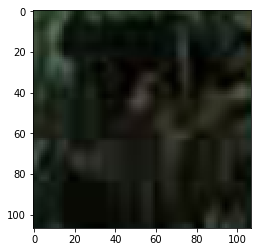

In [5]:
sample_generator = SampleGenerator('gaussian', image.size, 0.6, 1.05, valid=True)
pos_generator = SampleGenerator('gaussian', image.size, 0.1, 1.2)
neg_generator = SampleGenerator('uniform', image.size, 1.5, 1.2)
i=0
t_bbox = target_bbox[np.newaxis,:]
init_image = Image.open(img_list[0]).convert('RGB')
target_feat_fc5 = forward_samples(model,init_image,t_bbox,out_layer='fc5')
show_grid(init_image,t_bbox,1)
# Init pos/neg features for update
pos_feats_all = [pos_feats[:opts['n_pos_update']]]
neg_feats_all = [neg_feats[:opts['n_neg_update']]]

0.29253000020980835

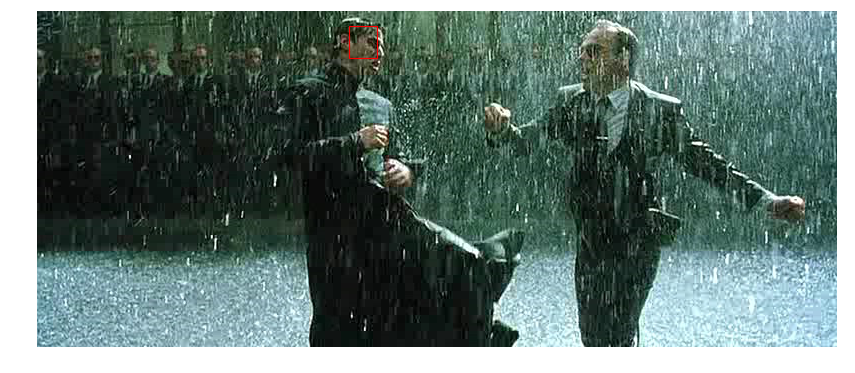

In [63]:
# iterating ........
i=i+1
image = Image.open(img_list[i]).convert('RGB')
# Estimate target bbox
samples = gen_samples(sample_generator, target_bbox, opts['n_samples'])
samples_feats_fc5 = forward_samples(model, image, samples,out_layer='fc5')

probFea = target_feat_fc5
galFea = samples_feats_fc5

diff = galFea-probFea
dist = torch.pow(diff,2).sum(dim=1)
original_dist = dist/torch.max(dist)
original_dist,initial_rank = torch.sort(original_dist)
#original_dist = original_dist.cpu().numpy()
#initial_rank = np.argsort(original_dist).astype(np.int32)

samples = samples[initial_rank,:]
target_bbox = samples[:5,:].mean(axis=0)

# Draw pos/neg samples
pos_examples = gen_samples(pos_generator, target_bbox, 
                            opts['n_pos_update'],
                            opts['overlap_pos_update'])
neg_examples = gen_samples(neg_generator, target_bbox, 
                            opts['n_neg_update'],
                            opts['overlap_neg_update'])

# Extract pos/neg features
pos_feats = forward_samples(model, image, pos_examples)
neg_feats = forward_samples(model, image, neg_examples)
pos_feats_all.append(pos_feats)
neg_feats_all.append(neg_feats)
if len(pos_feats_all) > opts['n_frames_long']:
    del pos_feats_all[0]
if len(neg_feats_all) > opts['n_frames_short']:
    del neg_feats_all[0]
    
show_result(image,target_bbox)
original_dist[initial_rank[:5]].mean()

In [300]:
update_optimizer = set_optimizer(model, opts['lr_update']*500)
pos_data = stackList(pos_feats_all)
neg_data = stackList(neg_feats_all)
train(model, pdist, update_optimizer, pos_data, neg_data, 50)

Variable containing:
 0.3770
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.3122
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.3140
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.5204
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1915
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.5287
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.5802
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.3952
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.4315
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1915
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.3328
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.3097
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.4003
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2582
[torch.cuda.FloatTenso

In [1]:

%matplotlib inline

In [5]:
x

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [10]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0,1,100)y1 = x - 0.35*x*np.sin(np.pi*x)*np.cos(np.pi*x)
y2 = x + 0.45*x*np.sin(np.pi*x)*np.cos(np.pi*x)
plt.plot(x,y1)
plt.plot(x,y2)
plt.axes().set_aspect('equal')
plt.savefig('1.pdf')
plt.show()

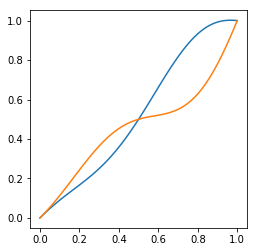